## Some common loss functions

There are several commonly used smooth loss functions built into
`regreg`:

* squared error loss (`regreg.api.squared_error`)

* Logistic loss (`regreg.glm.glm.logistic`)

* Poisson loss (`regreg.glm.glm.poisson`)

* Cox proportional hazards (`regreg.glm.glm.coxph`, depends on
  `statsmodels`)

* Huber loss (`regreg.glm.glm.huber`)

* Huberized SVM (`regreg.smooth.losses.huberized_svm`)

In [1]:
import numpy as np
import regreg.api as rr
import matplotlib.pyplot as plt

import rpy2.robjects as rpy2
from rpy2.robjects import numpy2ri
numpy2ri.activate()

X = np.random.standard_normal((100, 5))
X *= np.linspace(1, 3, 5)[None, :]
Y = np.random.binomial(1, 0.5, (100,))
loss = rr.glm.logistic(X, Y)
loss

$$
\ell^{\text{logit}}\left(X_{}\beta\right)
$$

In [2]:
rpy2.r.assign('X', X)
rpy2.r.assign('Y', Y)
r_soln = rpy2.r('glm(Y ~ X, family=binomial)$coef')
loss.solve()
np.array(r_soln)

array([ 0.03772602, -0.04863572, -0.08215854, -0.07378244,  0.04341304,
       -0.18794823])

The losses can very easily be combined with a penalty.

In [3]:
penalty = rr.l1norm(5, lagrange=2)
problem = rr.simple_problem(loss, penalty)
problem.solve(tol=1.e-12)

array([-0.        , -0.03926608, -0.05179897,  0.03680599, -0.1725902 ])

In [4]:
rpy2.r('''
library(glmnet)
Y = as.numeric(Y)
G = glmnet(X, Y, intercept=FALSE, standardize=FALSE, family='binomial')
print(coef(G, s=2 / nrow(X), x=X, y=Y, exact=TRUE))
''')

R[write to console]: Loading required package: Matrix



R[write to console]: Loading required package: foreach



R[write to console]: Loaded glmnet 2.0-18




6 x 1 sparse Matrix of class "dgCMatrix"


           1


(Intercept)

  .         


V1         

  .         


V2         

 -0.03926385


V3         

 -0.05179873


V4         

  0.03680646


V5         

 -0.17259009

R object with classes: ('dgCMatrix',) mapped to:

Suppose we want to match `glmnet` exactly without having to specify
`intercept=FALSE` and `standardize=FALSE`. The `normalize`
transformation can be used here.

In [5]:
n = X.shape[0]
X_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
X_normalized = rr.normalize(X_intercept, intercept_column=0, scale=False)
loss_normalized = rr.glm.logistic(X_normalized, Y)
penalty_normalized = rr.weighted_l1norm([0] + [1]*5, lagrange=2.)
problem_normalized = rr.simple_problem(loss_normalized, penalty_normalized)
coefR = problem_normalized.solve(tol=1.e-12, min_its=200)
coefR

array([-0.03968882, -0.        , -0.04130455, -0.05131366,  0.03490101,
       -0.17476366])

In [6]:
coefG = np.array(rpy2.r('as.numeric(coef(G, s=2 / nrow(X), exact=TRUE, x=X, y=Y))'))

In [7]:
problem_normalized.objective(coefG), problem_normalized.objective(coefR)

(65.90584223689014, 65.8867255949289)

In theory, using the `standardize=TRUE` option in `glmnet` should be
the same as using `scale=True, value=np.sqrt((n-1)/n)` in
`normalize`, though the results don’t match without some adjustment.
This is because `glmnet` returns coefficients that are on the scale of
the original $X$.

Dividing `regreg`’s coefficients by the `col_stds` corrects this.

In [8]:
X_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
X_normalized = rr.normalize(X_intercept, intercept_column=0,
                           value=np.sqrt((n-1.)/n))
loss_normalized = rr.glm.logistic(X_normalized, Y)
penalty_normalized = rr.weighted_l1norm([0] + [1]*5, lagrange=2.)
problem_normalized = rr.simple_problem(loss_normalized, penalty_normalized)
coefR = problem_normalized.solve(min_its=300)
coefR / X_normalized.col_stds

array([-0.04022662, -0.        , -0.02318002, -0.02853925,  0.01882133,
       -0.15450194])

In [9]:
rpy2.r('''
Y = as.numeric(Y)
G = glmnet(X, Y, standardize=TRUE, intercept=TRUE, family='binomial')
coefG = as.numeric(coef(G, s=2 / nrow(X), exact=TRUE, x=X, y=Y))
''')
coefG = np.array(rpy2.r('coefG'))

In [10]:
coefG = coefG * X_normalized.col_stds
problem_normalized.objective(coefG), problem_normalized.objective(coefR)
(67.64597880430388, 67.639665071862495)

(67.64597880430388, 67.6396650718625)

## Defining a new smooth function

A smooth function only really needs a `smooth_objective` method in
order to be used in `regreg`.

For example, suppose we want to define the loss

$$
\mu \mapsto \frac{1}{2} \|\mu\|^2_2  - \sum_{i=1}^k \log(b_i - a_i^T\mu)
$$

as a smooth approximation to the function

$$
  \mu \mapsto \frac{1}{2} \|\mu\|^2_2 + I^{\infty}_K(\mu)

where :math:`I^{\infty}_K` is the indicator of
$$

$K=\left\{\mu: a_i^T\mu\leq b_i, 1 \leq i \leq k\right\}$ (i.e. 0
inside $K$ and $\infty$ outside $K$).

In [11]:
class barrier(rr.smooth_atom):

    # the argumenets [coef, offset, quadratic, initial]
    # are passed when a function is composed with a linear_transform

    objective_template = r"""\ell^{\text{barrier}}\left(%(var)s\right)\
    """

    def __init__(self,
                 shape,
                 A,
                 b,
                 coef=1.,
                 offset=None,
                 quadratic=None,
                 initial=None):
        rr.smooth_atom.__init__(self,
                                shape,
                                coef=coef,
                                offset=offset,
                                quadratic=quadratic,
                                initial=initial)
        self.A = A
        self.b = b

    def smooth_objective(self, mean_param, mode='both', check_feasibility=False):
        mean_param = self.apply_offset(mean_param)
        slack = self.b - self.A.dot(mean_param)
        if mode == 'both':
            f = self.scale(np.sum(mean_param**2/2.) - np.log(slack).sum())
            g = self.scale(mean_param + self.A.T.dot(1. / slack))
            return f, g
        elif mode == 'grad':
            g = self.scale(mean_param + self.A.T.dot(1. / slack))
            return g
        elif mode == 'func':
            f = self.scale(np.sum(mean_param**2/2.) - np.log(slack).sum())
            return f
        else:
            return ValueError('mode incorrectly specified')

In [12]:
A = np.array([[1, 0.], [1, 1]])
b = np.array([3., 4])
barrier_loss = barrier((2,), A, b)
barrier_loss

$$
\ell^{\text{barrier}}\left(\beta\right)
$$

In [13]:
barrier_loss.solve(min_its=100)

array([-0.49815853, -0.21229384])

The loss can now be combined with a penalty or constraint very easily.

In [14]:
l1_bound = rr.l1norm(2, bound=0.5)
problem = rr.simple_problem(barrier_loss, l1_bound)
problem.solve()

array([-0.39719293, -0.10280707])

The loss can also be composed with a linear transform:

In [15]:
X = np.random.standard_normal((2,1))
lossX = rr.affine_smooth(barrier_loss, X)
lossX

affine_smooth(<__main__.barrier object at 0x12136b208>, <regreg.affine.linear_transform object at 0x12136b2b0>, store_grad=True)

$$
\ell^{\text{barrier}}\left(X_{}\beta\right)
$$

In [16]:
lossX.solve()

array([-0.34741628])

Huberized lasso

The Huberized lasso minimizes the following objective

$$
H_{\delta}(Y - X\beta) + \lambda \|\beta\|_1
$$

where $H_{\delta}(\cdot)$ is a function applied element-wise,

$$
 H_{\delta}(r) = \left\{\begin{array}{ll} r^2/2 & \mbox{ if } |r| \leq
\delta \\ \delta r - \delta^2/2 & \mbox{ else}\end{array} \right.
$$

Let’s look at the Huber loss for a smoothing parameter of
$\delta=1.2$

In [17]:
q = rr.identity_quadratic(1.2, 0., 0., 0.)
loss = rr.l1norm(1, lagrange=1).smoothed(q)
xval = np.linspace(-2,2,101)
yval = [loss.smooth_objective(x, 'func') for x in xval]
huber_fig = plt.figure(figsize=(8,8))
huber_ax = huber_fig.gca()
huber_ax.plot(xval, yval)

The Huber loss is built into regreg, but can also be obtained by
smoothing the `l1norm` atom. We will verify the two methods yield the
same solutions.

In [18]:
X = np.random.standard_normal((50, 10))
Y = np.random.standard_normal(50)

In [19]:
penalty = rr.l1norm(10,lagrange=5.)
loss_atom = rr.l1norm.affine(X, -Y, lagrange=1.).smoothed(rr.identity_quadratic(0.5,0,0,0))
loss = rr.glm.huber(X, Y, 0.5)

In [20]:
problem1 = rr.simple_problem(loss_atom, penalty)
print(problem1.solve(tol=1.e-12))

[-0.          0.          0.          0.00819026 -0.07042976  0.
 -0.         -0.07866935 -0.12959658  0.0055762 ]


In [21]:
problem2 = rr.simple_problem(loss, penalty)
print(problem2.solve(tol=1.e-12))

[-0.          0.          0.          0.00819044 -0.07042971  0.
 -0.         -0.07866952 -0.12959655  0.00557598]


# Poisson regression tutorial

The Poisson regression problem minimizes the objective

$$
-2 \left(Y^TX\beta - \sum_{i=1}^n \mbox{exp}(x_i^T\beta) \right), \qquad Y_i \in {0,1,2,\ldots}
$$

which corresponds to the usual Poisson regression model

$$
P(Y=y|X=x) = \frac{\mbox{exp}(y \cdot x^T\beta-\mbox{exp}(x^T\beta))}{y!}
$$

In [22]:
n = 100
p = 5
X = np.random.standard_normal((n,p))
Y = np.random.randint(0,100,n)

Now we can create the problem object, beginning with the loss function

In [23]:
loss = rr.glm.poisson(X, Y)
loss.solve()

/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:840: RuntimeWarning: divide by zero encountered in log
  loss_terms = - coef * ((counts - 1) * np.log(counts))
/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:887: RuntimeWarning: overflow encountered in exp
  exp_x = np.exp(x)


array([-0.2470568 , -1.10732254,  0.59664194,  0.82564975, -1.45966645])

In [24]:
rpy2.r.assign('Y', Y)
rpy2.r.assign('X', X)
np.array(rpy2.r('coef(glm(Y ~ X - 1, family=poisson()))'))

array([-0.24552094, -1.10726199,  0.59542001,  0.82873657, -1.45483286])

# Logistic regression with a ridge penalty

In `regreg`, ridge penalties can be specified by the `quadratic`
attribute of a loss (or a penalty).

The regularized ridge logistic regression problem minimizes the
objective

$$
-2\left(Y^TX\beta - \sum_i \log \left[ 1 + \exp(x_i^T\beta) \right] \right) + \lambda \|\beta\|_2^2
$$

which corresponds to the usual logistic regression model

$$
P(Y=1|X=x) = \mbox{logit}(x^T\beta) = \frac{1}{1 + \mbox{exp}(-x^T\beta)}
$$

Let’s generate some sample data.

In [25]:
X = np.random.standard_normal((200, 10))
Y = np.random.randint(0,2,200)

Now we can create the problem object, beginning with the loss function

In [26]:
loss = rr.glm.logistic(X, Y)
penalty = rr.identity_quadratic(1., 0., 0., 0.)
loss.quadratic = penalty
loss

$$
\ell^{\text{logit}}\left(X_{}\beta\right)
$$

In [27]:
penalty.coef
1.0

1.0

In [28]:
loss.solve()

array([-0.20900315,  0.11839588, -0.1813296 ,  0.14529937, -0.10693407,
        0.07222367,  0.28326734,  0.051914  ,  0.05141479, -0.1229806 ])

In [29]:
penalty.coef = 20.
loss.solve()

array([-0.14636856,  0.08683651, -0.12888217,  0.09303803, -0.07941929,
        0.04877304,  0.21071889,  0.03228041,  0.0328905 , -0.08097988])

# Multinomial regression

The multinomial regression problem minimizes the objective

$$
-\left[ \sum_{j=1}^{J-1} \sum_{k=1}^p \beta_{jk}\sum_{i=1}^n x_{ik}y_{ij}
 - \sum_{i=1}^n \log \left(1 + \mbox{exp}(x_i^T\beta_j) \right)\right]
$$

which corresponds to a baseline category logit model for $J$
nominal categories (e.g. Agresti, p.g. 272). For $i \ne J$ the
probabilities are measured relative to a baseline category $J$

$$
\frac{P(\mbox{Category } i)}{P(\mbox{Category } J)} = \mbox{logit}(x^T\beta_i) = \frac{1}{1 + \mbox{exp}(-x^T\beta_i)}
$$

In [30]:
from regreg.smooth.glm import multinomial_loglike

The only code needed to add multinomial regression to RegReg is a class
with one method which computes the objective and its gradient.

Next, let’s generate some example data. The multinomial counts will be
stored in a $n \times J$ array

In [31]:
J = 5
n = 500
p = 10
X = np.random.standard_normal((n,p))
Y = np.random.randint(0,10,n*J).reshape((n,J))

Now we can create the problem object, beginning with the loss function.
The coefficients will be stored in a $p \times (J-1)$ array, and
we need to let RegReg know that the coefficients will be a 2d array
instead of a vector. We can do this by defining the input_shape in a
linear_transform object that multiplies by X,

In [32]:
multX = rr.linear_transform(X, input_shape=(p,J-1))
loss = rr.multinomial_loglike.linear(multX, counts=Y)
loss.shape

/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:1114: RuntimeWarning: divide by zero encountered in log
  loss_terms = np.log(saturated) * self.counts
/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:1114: RuntimeWarning: invalid value encountered in multiply
  loss_terms = np.log(saturated) * self.counts


(10, 4)

Next, we can solve the problem

In [33]:
loss.solve()

array([[ 0.0548204 ,  0.02639891,  0.06349326,  0.05484217],
       [-0.00801381, -0.05425095, -0.00092391,  0.01554628],
       [ 0.02863027,  0.04296675,  0.01209194, -0.00340814],
       [-0.00482727, -0.04333662, -0.01714575, -0.02382563],
       [ 0.04011513,  0.05115482,  0.02824501,  0.02031728],
       [ 0.02297367,  0.02673593,  0.06309896,  0.04316998],
       [ 0.03164772,  0.03662476, -0.01244323,  0.01106618],
       [ 0.01161456,  0.03501517, -0.00586908, -0.01117148],
       [ 0.004103  ,  0.01089722,  0.02079106,  0.02713465],
       [-0.01233972,  0.03607589,  0.02923168, -0.04108609]])

When $J=2$ this model should reduce to logistic regression. We can
easily check that this is the case by first fitting the multinomial
model

In [34]:
J = 2
Y = np.random.randint(0,10,n*J).reshape((n,J))
multX = rr.linear_transform(X, input_shape=(p,J-1))
loss = rr.multinomial_loglike.linear(multX, counts=Y)
solver = rr.FISTA(loss)
solver.fit(tol=1e-6)
multinomial_coefs = solver.composite.coefs.flatten()

/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:1113: RuntimeWarning: invalid value encountered in true_divide
  saturated = self.counts / (1. * self.trials[:,np.newaxis])
/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:1114: RuntimeWarning: divide by zero encountered in log
  loss_terms = np.log(saturated) * self.counts
/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:1114: RuntimeWarning: invalid value encountered in multiply
  loss_terms = np.log(saturated) * self.counts


Here is the equivalent logistic regresison model.

In [35]:
successes = Y[:,0]
trials = np.sum(Y, axis=1)
loss = rr.glm.logistic(X, successes, trials=trials)
solver = rr.FISTA(loss)
solver.fit(tol=1e-6)
logistic_coefs = solver.composite.coefs

/Users/jonathantaylor/git-repos/regreg/regreg/smooth/glm.py:615: RuntimeWarning: invalid value encountered in true_divide
  saturated = self.successes / self.trials


Finally we can check that the two models gave the same coefficients

In [36]:
print(np.linalg.norm(multinomial_coefs - logistic_coefs) / np.linalg.norm(logistic_coefs))

1.9565979769201473e-16


## Hinge loss

The SVM can be parametrized various ways, one way to write it as a
regression problem is to use the hinge loss:

$$
\ell(r) = \max(1-x, 0)
$$

In [37]:
hinge = lambda x: np.maximum(1-x, 0)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
r = np.linspace(-1,2,100)
ax.plot(r, hinge(r))

The SVM loss is then

$$
\ell(\beta) = C \sum_{i=1}^n h(Y_i X_i^T\beta) + \frac{1}{2} \|\beta\|^2_2
$$

where $Y_i \in \{-1,1\}$ and $X_i \in \mathbb{R}^p$ is one
of the feature vectors.

In regreg, the hinge loss can be represented by composition of some of
the basic atoms. Specifcally, let
$g:\mathbb{R}^n \rightarrow \mathbb{R}$ be the sum of positive
part function

$$
g(z) = \sum_{i=1}^n\max(z_i, 0).
$$

Then,

$$
  \ell(\beta) = g\left(Y \cdot X\beta \right)

where the product in the parentheses is elementwise multiplication.
$$

In [38]:
linear_part = np.array([[-1.]])
offset = np.array([1.])
hinge_rep = rr.positive_part.affine(linear_part, offset, lagrange=1.)
hinge_rep

affine_atom(positive_part((1,), lagrange=1.000000, offset=array([-1.])), array([[-1.]]))

$$
\lambda_{} \left(\sum_{i=1}^{p} (X_{}\beta - \alpha_{})_i^+\right)
$$

Let’s plot the loss to be sure it agrees with our original hinge.

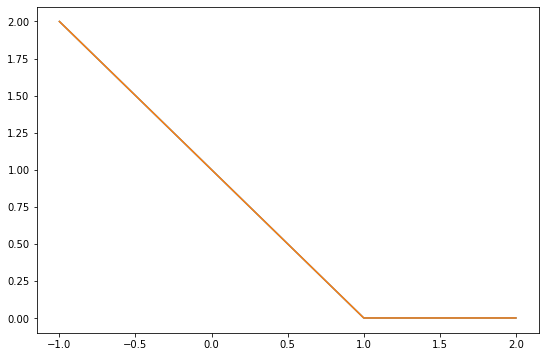

In [39]:
ax.plot(r, [hinge_rep.nonsmooth_objective(v) for v in r])
fig

Here is a vectorized version.

In [40]:
N = 1000
P = 200
Y = 2 * np.random.binomial(1, 0.5, size=(N,)) - 1.
X = np.random.standard_normal((N,P))
#X[Y==1] += np.array([30,-20] + (P-2)*[0])[np.newaxis,:]
X -= X.mean(0)[np.newaxis, :]
hinge_vec = rr.positive_part.affine(-Y[:, None] * X, np.ones_like(Y), lagrange=1.)

In [41]:
beta = np.ones(X.shape[1])
hinge_vec.nonsmooth_objective(beta), np.maximum(1 - Y * X.dot(beta), 0).sum()

(6813.323424537586, 6813.323424537586)

# Smoothed hinge

For optimization, the hinge loss is not differentiable so it is often
smoothed first.

The smoothing is applicable to general functions of the form

$$
g(X\beta-\alpha) = g_{\alpha}(X\beta)
$$

where $g_{\alpha}(z) = g(z-\alpha)$ and is determined by a small
quadratic term

$$
q(z) = \frac{C_0}{2} \|z-x_0\|^2_2 + v_0^Tz + c_0.
$$

In [42]:
epsilon = 0.5
smoothing_quadratic = rr.identity_quadratic(epsilon, 0, 0, 0)
smoothing_quadratic

identity_quadratic(0.500000, 0.0, 0.0, 0.000000)

$$
\begin{equation*} \frac{L_{}}{2}\|\beta\|^2_2 \end{equation*}
$$

The quadratic terms are determined by four parameters with
$(C_0, x_0, v_0, c_0)$.

Smoothing of the function by the quadratic $q$ is performed by
Moreau smoothing:

$$
S(g_{\alpha},q)(\beta) = \sup_{z \in \mathbb{R}^p} z^T\beta - g^*_{\alpha}(z) - q(z)
$$

where

$$
  g^*_{\alpha}(z) = \sup_{\beta \in \mathbb{R}^p} z^T\beta - g_{\alpha}(\beta)

is the convex (Fenchel) conjugate of the composition :math:`g` with the
$$

translation by $-\alpha$.

The basic atoms in `regreg` know what their conjugate is. Our hinge
loss, `hinge_rep`, is the composition of an `atom`, and an affine
transform. This affine transform is split into two pieces, the linear
part, stored as `linear_transform` and its offset stored as
`atom.offset`. It is stored with `atom` as `atom` needs knowledge
of this when computing proximal maps.

In [43]:
hinge_rep.atom

positive_part((1,), lagrange=1.000000, offset=array([-1.]))

$$
\lambda_{} \left(\sum_{i=1}^{p} (\beta - \alpha_{})_i^+\right)
$$

In [44]:
hinge_rep.atom.offset

array([-1.])

In [45]:
hinge_rep.linear_transform.linear_operator

array([[-1.]])

As we said before, `hinge_rep.atom` knows what its conjugate is

In [46]:
hinge_conj = hinge_rep.atom.conjugate
hinge_conj

constrained_max((1,), bound=1.000000, offset=None, quadratic=identity_quadratic(0.000000, 0.0, array([-1.]), 0.000000))

$$
I^{\infty}(\left\|\beta\right\|_{\infty} + I^{\infty}\left(\min(\beta) \in [0,+\infty)\right)  \leq \delta_{}) + \left \langle \eta_{}, \beta \right \rangle
$$

The notation $I^{\infty}$ denotes a constraint. The expression can
therefore be parsed as a linear function $\eta^T\beta$ plus the
function

$$
g^*(z) = \begin{cases}
0 & 0 \leq z_i \leq \delta \, \forall i \\
\infty & \text{otherwise.}
\end{cases}
$$

The term $\eta$ is derived from `hinge_rep.atom.offset` and is
stored in `hinge_conj.quadratic`.

In [47]:
hinge_conj.quadratic.linear_term

array([-1.])

Now, let’s look at the smoothed hinge loss.

In [48]:
smoothed_hinge_loss = hinge_rep.smoothed(smoothing_quadratic)
smoothed_hinge_loss

affine_smooth(smooth_conjugate(constrained_max((1,), bound=1.000000, offset=None, quadratic=identity_quadratic(0.500000, 0.0, array([-1.]), 0.000000)),identity_quadratic(0.500000, 0.0, array([-1.]), 0.000000)), <regreg.affine.linear_transform object at 0x12135e550>, store_grad=True)

$$
\sup_{u \in \mathbb{R}^{p} } \left[ \langle X_{}\beta, u \rangle - \left(I^{\infty}(\left\|u\right\|_{\infty} + I^{\infty}\left(\min(u) \in [0,+\infty)\right)  \leq \delta_{}) + \frac{L_{}}{2}\|u\|^2_2 + \left \langle \eta_{}, u \right \rangle \right) \right]
$$

It is now a smooth function and its objective value and gradient can be
computed with `smooth_objective`.

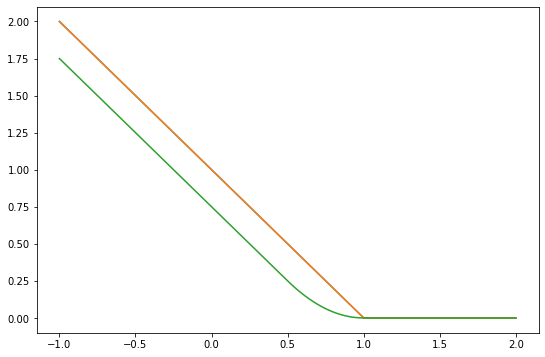

In [49]:
ax.plot(r, [smoothed_hinge_loss.smooth_objective(v, 'func') for v in r])
fig

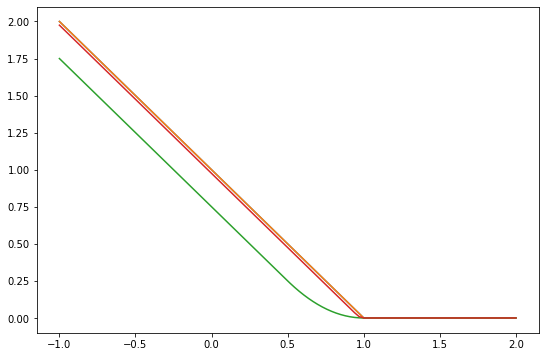

In [50]:
less_smooth = hinge_rep.smoothed(rr.identity_quadratic(5.e-2, 0, 0, 0))
ax.plot(r, [less_smooth.smooth_objective(v, 'func') for v in r])
fig

# Fitting the SVM

We can now minimize this objective.

In [51]:
smoothed_vec = hinge_vec.smoothed(rr.identity_quadratic(0.2, 0, 0, 0))
soln = smoothed_vec.solve(tol=1.e-12, min_its=100)

# Sparse SVM

We might want to fit a sparse version, adding a sparsifying penalty like
the LASSO. This yields the problem

$$
\text{minimize}_{\beta} \ell(\beta) + \lambda \|\beta\|_1
$$

In [52]:
penalty = rr.l1norm(smoothed_vec.shape, lagrange=20)
problem = rr.simple_problem(smoothed_vec, penalty)
problem

$$
\begin{aligned}
\text{minimize}_{\beta} & f(\beta) + g(\beta) \\
f(\beta) &=  \sup_{u \in \mathbb{R}^{p} } \left[ \langle X_{1}\beta, u \rangle - \left(I^{\infty}(\left\|u\right\|_{\infty} + I^{\infty}\left(\min(u) \in [0,+\infty)\right)  \leq \delta_{1}) + \frac{L_{1}}{2}\|u\|^2_2 + \left \langle \eta_{1}, u \right \rangle \right) \right] \\
g(\beta) &= \lambda_{2} \|\beta\|_1 \\
\end{aligned}
$$

In [53]:
sparse_soln = problem.solve(tol=1.e-12)
sparse_soln

array([-0.11794475,  0.08667502,  0.        , -0.0634286 ,  0.04145064,
        0.        ,  0.12536322, -0.        ,  0.        , -0.09668681,
        0.05306269,  0.        , -0.01064823, -0.        ,  0.0377666 ,
        0.        , -0.08346559, -0.1200484 ,  0.        , -0.00345114,
        0.        , -0.        , -0.        , -0.02736643,  0.01014732,
       -0.0830704 ,  0.        ,  0.        , -0.05251217, -0.        ,
        0.03145735, -0.01476226,  0.        ,  0.04094988, -0.09225357,
        0.16668443, -0.0068806 ,  0.        , -0.06944853, -0.        ,
        0.        ,  0.        ,  0.        ,  0.06859081,  0.        ,
       -0.        , -0.02868384, -0.        ,  0.05566649,  0.        ,
       -0.        , -0.        , -0.06390489, -0.        ,  0.        ,
       -0.13076543,  0.        ,  0.05820014, -0.03504912, -0.        ,
        0.00298815,  0.06577031,  0.        ,  0.        , -0.02236921,
        0.        , -0.        , -0.        ,  0.00310002, -0.  

What value of $\lambda$ should we use? For the $\ell_1$
penalty in Lagrange form, the smallest $\lambda$ such that the
solution is zero can be found by taking the dual norm, the
$\ell_{\infty}$ norm, of the gradient of the smooth part at 0.

In [54]:
linf_norm = penalty.conjugate
linf_norm

supnorm((200,), bound=20.000000, offset=None)

$$
I^{\infty}(\|\beta\|_{\infty} \leq \delta_{})
$$

Just computing the conjugate will yield an $\ell_{\infty}$
constraint, but this object can still be used to compute the desired
value of $\lambda$.

In [55]:
score_at_zero = smoothed_vec.smooth_objective(np.zeros(smoothed_vec.shape), 'grad')
lam_max = linf_norm.seminorm(score_at_zero, lagrange=1.)
lam_max

90.06739154192712

In [56]:
penalty.lagrange = lam_max * 1.001
problem.solve(tol=1.e-12, min_its=200)

array([-0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,
        0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,
        0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0., -0.,
       -0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,
       -0., -0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,
       -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0., -0., -0., -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0.,  0.,
       -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
       -0.,  0., -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0.,
       -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,
        0., -0.,  0.,  0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,
       -0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,
        0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0

In [57]:
penalty.lagrange = lam_max * 0.99
problem.solve(tol=1.e-12, min_its=200)

array([-0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.  

## Path of solutions

If we want a path of solutions, we can simply take multiples of
`lam_max`. This is similar to the strategy that packages like
`glmnet` use

In [58]:
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max)[::-1]
for lam_val in lam_vals:
    penalty.lagrange = lam_val
    path.append(problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

Changing the penalty

We may not want to penalize features the same. We may want some features
to be unpenalized. This can be achieved by introducing possibly non-zero
feature weights to the $\ell_1$ norm

$$
\beta \mapsto \sum_{j=1}^p w_j|\beta_j|
$$

In [59]:
weights = np.random.sample(P) + 1.
weights[:5] = 0.
weighted_penalty = rr.weighted_l1norm(weights, lagrange=1.)
weighted_penalty

l1norm([0.         0.         0.         0.         0.         1.87296458
 1.18891642 1.91698625 1.70801345 1.57996509 1.08922197 1.83593569
 1.10172778 1.95641938 1.71838292 1.66352323 1.70349313 1.80109366
 1.25404202 1.25903633 1.65460983 1.6920795  1.41797663 1.92520815
 1.7335934  1.29442753 1.44168013 1.60128268 1.66240986 1.16660547
 1.27271487 1.00144935 1.52929368 1.25449996 1.19666245 1.77042046
 1.8229748  1.47209586 1.14098216 1.77038834 1.03449807 1.79150344
 1.12021593 1.59620413 1.16008248 1.52955354 1.5361846  1.84017027
 1.69099274 1.72173419 1.63190979 1.04230409 1.99959201 1.1458063
 1.75472996 1.44436963 1.17142941 1.41738061 1.0372572  1.45189326
 1.26096963 1.80290619 1.5144726  1.78357967 1.49870195 1.81307546
 1.42599743 1.8702529  1.36186565 1.12848694 1.61653581 1.2054714
 1.29042584 1.67678491 1.25786305 1.05517905 1.19010324 1.48372219
 1.93900183 1.51204541 1.79871647 1.39977394 1.34848333 1.38318479
 1.88176022 1.50036102 1.55659098 1.64742839 1.09221121 1

$$
\lambda_{} \|W\beta\|_1
$$

In [60]:
weighted_dual = weighted_penalty.conjugate
weighted_dual

supnorm([       inf        inf        inf        inf        inf 0.53391293
 0.84110202 0.52165215 0.58547548 0.63292538 0.91808651 0.54468139
 0.90766523 0.51113785 0.58194247 0.60113378 0.58702908 0.55521821
 0.79742144 0.79425825 0.60437209 0.59098878 0.70523024 0.51942435
 0.57683653 0.77254228 0.69363514 0.62449935 0.60153637 0.85718782
 0.78572194 0.99855275 0.65389664 0.79713036 0.83565754 0.56483757
 0.54855393 0.67930359 0.87643789 0.56484782 0.96665236 0.55819039
 0.89268504 0.62648629 0.86200767 0.65378555 0.65096343 0.54342797
 0.59136859 0.58080975 0.61277897 0.95941291 0.50010202 0.87274787
 0.56988826 0.69234355 0.85365792 0.7055268  0.96408104 0.68875587
 0.79304051 0.55466003 0.66029587 0.56067022 0.66724408 0.55154902
 0.70126354 0.53468705 0.73428682 0.88614229 0.61860677 0.829551
 0.77493799 0.59637941 0.7949991  0.94770646 0.84026323 0.67398062
 0.51572927 0.6613558  0.55595199 0.71440107 0.74157387 0.7229692
 0.53141733 0.66650625 0.64242952 0.60700666 0.91557383 0

$$
I^{\infty}(\|W\beta\|_{\infty} \leq \delta_{})
$$

In [61]:
lam_max_weight = weighted_dual.seminorm(score_at_zero, lagrange=1.)
lam_max_weight

67.27348860880447

In [62]:
weighted_problem = rr.simple_problem(smoothed_vec, weighted_penalty)
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max_weight)[::-1]
for lam_val in lam_vals:
    weighted_penalty.lagrange = lam_val
    path.append(weighted_problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

Note that there are 5 coefficients that are not penalized hence they are
nonzero the entire path.

Variables may come in groups. A common penalty for this setting is the
group LASSO. Let

$$
\{1, \dots, p\} = \cup_{g \in G} g
$$

be a partition of the set of features and $w_g$ a weight for each
group. The group LASSO penalty is

$$
\beta \mapsto \sum_{g \in G} w_g \|\beta_g\|_2.
$$

In [63]:
groups = []
for i in range(int(P/5)):
    groups.extend([i]*5)
weights = dict([g, np.random.sample()+1] for g in np.unique(groups))
group_penalty = rr.group_lasso(groups, weights=weights, lagrange=1.)

In [64]:
group_dual = group_penalty.conjugate
lam_max_group = group_dual.seminorm(score_at_zero, lagrange=1.)

In [65]:
group_problem = rr.simple_problem(smoothed_vec, group_penalty)
path = []
lam_vals = (np.linspace(0.05, 1.01, 50) * lam_max_group)[::-1]
for lam_val in lam_vals:
    group_penalty.lagrange = lam_val
    path.append(group_problem.solve(min_its=200).copy())
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
path = np.array(path)
ax.plot(path);

As expected, variables enter in groups here.

## Bound form

The common norm atoms also have a bound form. That is, we can just as
easily solve the problem

$$
\text{minimize}_{\beta: \|\beta\|_1 \leq \delta}\ell(\beta)
$$

In [66]:
bound_l1 = rr.l1norm(P, bound=2.)
bound_l1

l1norm((200,), bound=2.000000, offset=None)

$$
I^{\infty}(\|\beta\|_1 \leq \delta_{})
$$

In [67]:
bound_problem = rr.simple_problem(smoothed_vec, bound_l1)
bound_problem

$$
\begin{aligned}
\text{minimize}_{\beta} & f(\beta) + g(\beta) \\
f(\beta) &=  \sup_{u \in \mathbb{R}^{p} } \left[ \langle X_{1}\beta, u \rangle - \left(I^{\infty}(\left\|u\right\|_{\infty} + I^{\infty}\left(\min(u) \in [0,+\infty)\right)  \leq \delta_{1}) + \frac{L_{1}}{2}\|u\|^2_2 + \left \langle \eta_{1}, u \right \rangle \right) \right] \\
g(\beta) &= I^{\infty}(\|\beta\|_1 \leq \delta_{2}) \\
\end{aligned}
$$

In [68]:
bound_soln = bound_problem.solve()
np.fabs(bound_soln).sum()

2.0000000000000004

Support vector machine

This tutorial illustrates one version of the support vector machine, a
linear example. The minimization problem for the support vector machine,
following *ESL* is

$$
\text{minimize}_{\beta,\gamma} \sum_{i=1}^n (1- y_i(x_i^T\beta+\gamma))^+ + \frac{\lambda}{2} \|\beta\|^2_2
$$

We use the $C$ parameterization in (12.25) of *ESL*

$$
\text{minimize}_{\beta,\gamma} C \sum_{i=1}^n (1- y_i(x_i^T\beta+\gamma))^+  + \frac{1}{2} \|\beta\|^2_2
$$

This is an example of the positive part atom combined with a smooth
quadratic penalty. Above, the $x_i$ are rows of a matrix of
features and the $y_i$ are labels coded as $\pm 1$.

Let’s generate some data appropriate for this problem.

In [69]:
import numpy as np
>>>
np.random.seed(400) # for reproducibility
N = 500
P = 2
>>>
Y = 2 * np.random.binomial(1, 0.5, size=(N,)) - 1.
X = np.random.standard_normal((N,P))
X[Y==1] += np.array([3,-2])[np.newaxis,:]
X -= X.mean(0)[np.newaxis,:]

In [70]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])
clf.fit(X, y)
print(clf.coef_, clf.dual_coef_, clf.support_)

[[0.5 0.5]] [[-0.25  0.25]] [0 2]


The hinge loss is not smooth, but it can be written as the composition
of an `atom` (`positive_part`) with an affine transform determined
by the data.

Such objective functions can be smoothed. [NESTA](TODO) and
[TFOCS](TODO) describe schemes in which smoothing of these atoms can
be used to produce optimization problems with smooth objectives which
can have additional structure imposed through optimization.

Let us try smoothing the objective and using NESTA by smoothing the
hinge loss. Of course, one can also solve the usual SVC dual problem by
smoothing.

In [71]:
def nesta_svm(X, y_pm, C=1.):
    n, p = X.shape
    X_1 = np.hstack([X, np.ones((X.shape[0], 1))])
    hinge_loss = rr.positive_part.affine(-y_pm[:,None] * X_1, + np.ones(n),
                                        lagrange=C)
    selector = np.identity(p+1)[:p]
    smooth_ = rr.quadratic_loss.linear(selector)
    soln = rr.nesta(smooth_, None, hinge_loss)
    return soln[0][:-1], soln[1]

nesta_svm(X, 2 * (y - 1.5))

(array([0.54059898, 0.44468378]),
 array([0.23285573, 0.        , 0.23285573, 0.        ]))

Let’s try a little larger data set.

In [72]:
X_l = np.random.standard_normal((100, 20))
Y_l = 2 * np.random.binomial(1, 0.5, (100,)) - 1
C = 4.
clf = SVC(kernel='linear', C=C)
clf.fit(X_l, Y_l)
clf.coef_

array([[ 0.03392693, -0.91351163, -0.0260219 , -0.29037068, -0.34668033,
        -0.48974048, -0.34711183,  0.71658591,  0.05415365, -0.23807212,
        -0.57111301, -0.21825985, -0.1718904 ,  0.34680402,  0.23467808,
         0.17192434, -0.01959738,  0.15147373,  0.07052722,  0.11660805]])

In [73]:
solnR_ = nesta_svm(X_l, Y_l, C=C)[0]
plt.scatter(clf.coef_, solnR_)
plt.plot([-1,1], [-1,1])

Using `regreg`, we can easily add penalty or constraint to the SVM
objective.

In [74]:
def nesta_svm_pen(X, y_pm, atom, C=1.):
    n, p = X.shape
    X_1 = np.hstack([X, np.ones((X.shape[0], 1))])
    hinge_loss = rr.positive_part.affine(-y_pm[:,None] * X_1, + np.ones(n),
                                        lagrange=C)
    selector = np.identity(p+1)[:p]
    smooth_ = rr.quadratic_loss.linear(selector)
    atom_sep = rr.separable((p+1,), [atom], [slice(0,p)])
    soln = rr.nesta(smooth_, atom_sep, hinge_loss)
    return soln[0][:-1]

bound = rr.l1norm(20, bound=0.8)
nesta_svm_pen(X_l, Y_l, bound)

array([ 0.        , -0.20155192,  0.        ,  0.        ,  0.        ,
       -0.03334131, -0.14715379,  0.17509434, -0.        , -0.        ,
       -0.13078627,  0.        ,  0.        ,  0.02394207,  0.0756029 ,
        0.01252739, -0.        , -0.        , -0.        , -0.        ])

## Sparse Huberized SVM

Instead of using NESTA we can just smooth the SVM with a fixed smoothing
parameter and solve the problem directly.

In [75]:
from regreg.smooth.losses import huberized_svm
X_l_inter = np.hstack([X_l, np.ones((X_l.shape[0],1))])
huber_svm = huberized_svm(X_l_inter, Y_l, smoothing_parameter=0.001, coef=C)
coef_h = huber_svm.solve(min_its=100)[:-1]
plt.scatter(coef_h, clf.coef_)

Adding penalties or constraints is again straightforward.

In [76]:
penalty = rr.l1norm(X_l.shape[1], lagrange=8.)
penalty_sep = rr.separable((X_l.shape[1]+1,), [penalty], [slice(0,X_l.shape[1])])
huberized_problem = rr.simple_problem(huber_svm, penalty_sep)
huberized_problem.solve()
numpy2ri.deactivate()